In [1]:
%matplotlib inline
import numpy as np
import time
from linear_solvers import NumPyLinearSolver, HHL
from qiskit.quantum_info import Statevector
from qiskit import *
from qiskit.tools.visualization import plot_histogram


def get_solution_vector(solution):
    """Extracts and normalizes simulated state vector
    from LinearSolverResult."""
    solution_vector = Statevector(solution.state).data[16:18].real
    norm = solution.euclidean_norm
    return norm * solution_vector / np.linalg.norm(solution_vector)


Naive Solution
 -0.33846235275268555 seconds
 {   'circuit_results': None,
    'euclidean_norm': 1.1858541225631376,
    'observable': None,
    'state': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f9fa4676c50>}
naive raw solution vector: [0.75+3.47755428e-16j 0.25+1.16143956e-16j]
full naive solution vector: [1.125 0.375]
      ┌─────────────┐┌──────┐        ┌─────────┐
  q4: ┤ circuit-127 ├┤3     ├────────┤3        ├
      └─────────────┘│      │┌──────┐│         │
q5_0: ───────────────┤0     ├┤2     ├┤0        ├
                     │  QPE ││      ││  QPE_dg │
q5_1: ───────────────┤1     ├┤1     ├┤1        ├
                     │      ││  1/x ││         │
q5_2: ───────────────┤2     ├┤0     ├┤2        ├
                     └──────┘│      │└─────────┘
  q6: ───────────────────────┤3     ├───────────
                             └──────┘           


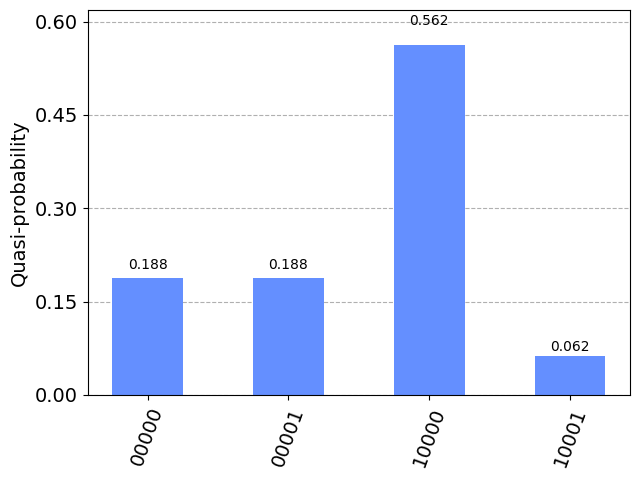

In [2]:
matrix = np.array([ [1, -1/3], [-1/3, 1] ])
vector = np.array([1, 0])

start_time = time.time()
naive_hhl_solution = HHL().solve(matrix, vector)
end_time = time.time()
print('Naive Solution\n', start_time - end_time, 'seconds\n', naive_hhl_solution)

naive_sv = Statevector(naive_hhl_solution.state).data
naive_full_vector = np.array([naive_sv[16], naive_sv[17]])

# Raw vector = components expressed complex numbers
# Full vector = components expressed in the real numbers
print('naive raw solution vector:', naive_full_vector)
print('full naive solution vector:', get_solution_vector(naive_hhl_solution))
print(naive_hhl_solution.state)

simulator = Aer.get_backend('statevector_simulator')
res = execute(naive_hhl_solution.state, backend=simulator, shots=1024).result()
plot_histogram(res.get_counts())


In [3]:
start_time = time.time()
classical_solution = NumPyLinearSolver().solve(matrix,
                                               vector/np.linalg.norm(vector))
end_time = time.time()
print('Classical Solution', start_time - end_time, 'seconds\n', classical_solution.state)


Classical Solution -0.0002837181091308594 seconds
 [1.125 0.375]


In [4]:
t = 2  # This is not optimal; As an exercise, set this to the
       # value that will get the best results. See section 8 for solution.

NUM_QUBITS = 4  # Total number of qubits
nb = 1  # Number of qubits representing the solution
nl = 2  # Number of qubits representing the eigenvalues

theta = 0  # Angle defining |b>

a = 1  # Matrix diagonal
b = -1/3  # Matrix off-diagonal

# Initialize the quantum and classical registers
qr = QuantumRegister(NUM_QUBITS)

# Create a Quantum Circuit
qc = QuantumCircuit(qr)

qrb = qr[0:nb]
qrl = qr[nb:nb+nl]
qra = qr[nb+nl:nb+nl+1]

# State preparation.
qc.ry(2*theta, qrb[0])

# QPE with e^{iAt}
for qu in qrl:
    qc.h(qu)

qc.p(a*t, qrl[0])
qc.p(a*t*2, qrl[1])

qc.u(b*t, -np.pi/2, np.pi/2, qrb[0])


# Controlled e^{iAt} on \lambda_{1}:
params=b*t

qc.p(np.pi/2,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[0],qrb[0])
qc.ry(-params,qrb[0])
qc.p(3*np.pi/2,qrb[0])

# Controlled e^{2iAt} on \lambda_{2}:
params = b*t*2

qc.p(np.pi/2,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(params,qrb[0])
qc.cx(qrl[1],qrb[0])
qc.ry(-params,qrb[0])
qc.p(3*np.pi/2,qrb[0])

# Inverse QFT
qc.h(qrl[1])
qc.rz(-np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(np.pi/4,qrl[1])
qc.cx(qrl[0],qrl[1])
qc.rz(-np.pi/4,qrl[0])
qc.h(qrl[0])

# Eigenvalue rotation
t1=(-np.pi +np.pi/3 - 2*np.arcsin(1/3))/4
t2=(-np.pi -np.pi/3 + 2*np.arcsin(1/3))/4
t3=(np.pi -np.pi/3 - 2*np.arcsin(1/3))/4
t4=(np.pi +np.pi/3 + 2*np.arcsin(1/3))/4

qc.cx(qrl[1],qra[0])
qc.ry(t1,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t2,qra[0])
qc.cx(qrl[1],qra[0])
qc.ry(t3,qra[0])
qc.cx(qrl[0],qra[0])
qc.ry(t4,qra[0])
qc.measure_all()

print(f"Depth: {qc.depth()}")
print(f"CNOTS: {qc.count_ops()['cx']}")
qc.draw(fold=-1)

Depth: 26
CNOTS: 10


┌───────┐┌──────────────────────┐┌────────┐┌───┐┌──────────────┐┌───┐┌─────────────┐┌─────────┐┌────────┐┌───┐┌─────────────┐┌───┐┌────────────┐┌─────────┐                                                                                                               ░ ┌─┐         
 q42_0: ┤ Ry(0) ├┤ U(-0.66667,-π/2,π/2) ├┤ P(π/2) ├┤ X ├┤ Ry(-0.66667) ├┤ X ├┤ Ry(0.66667) ├┤ P(3π/2) ├┤ P(π/2) ├┤ X ├┤ Ry(-1.3333) ├┤ X ├┤ Ry(1.3333) ├┤ P(3π/2) ├───────────────────────────────────────────────────────────────────────────────────────────────────────────────░─┤M├─────────
        └─┬───┬─┘└───────┬──────┬───────┘└────────┘└─┬─┘└──────────────┘└─┬─┘└─────────────┘└─────────┘└────────┘└─┬─┘└─────────────┘└─┬─┘└────────────┘└─────────┘                      ┌──────────┐     ┌───┐                                                                   ░ └╥┘┌─┐      
 q42_1: ──┤ H ├──────────┤ P(2) ├────────────────────■────────────────────■────────────────────────────────────────┼───────────────────┼──────────────────────────────■───────────────■──┤ Rz(-π/4) ├─────┤ H ├────────■────────────────────────────────────────■─────────────────░──╫─┤M├──────
          ├───┤          ├──────┤                                                                                  │                   │      ┌───┐     ┌──────────┐┌─┴─┐┌─────────┐┌─┴─┐└──────────┘     └───┘        │                                        │                 ░  ║ └╥┘┌─┐   
 q42_2: ──┤ H ├──────────┤ P(4) ├──────────────────────────────────────────────────────────────────────────────────■───────────────────■──────┤ H ├─────┤ Rz(-π/4) ├┤ X ├┤ Rz(π/4) ├┤ X ├─────■────────────────────────┼────────────────────■───────────────────┼─────────────────░──╫──╫─┤M├───
          └───┘          └──────┘                                                                                                             └───┘     └──────────┘└───┘└─────────┘└───┘   ┌─┴─┐    ┌──────────────┐┌─┴─┐┌──────────────┐┌─┴─┐┌─────────────┐┌─┴─┐┌────────────┐ ░  ║  ║ └╥┘┌─┐
 q42_3: ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤ X ├────┤ Ry(-0.69352) ├┤ X ├┤ Ry(-0.87728) ├┤ X ├┤ Ry(0.35368) ├┤ X ├┤ Ry(1.2171) ├─░──╫──╫──╫─┤M├
                                                                                                                                                                                            └───┘    └──────────────┘└───┘└──────────────┘└───┘└─────────────┘└───┘└────────────┘ ░  ║  ║  ║ └╥┘
meas: 4/═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══╩══╩══╩═
                                                                                                                                                                                                                                                                                     0  1  2  3

In [8]:
from qiskit import IBMQ, transpile
from qiskit.utils.mitigation import complete_meas_cal

provider = IBMQ.load_account()

backend = provider.get_backend('ibm_osaka') # calibrate using real hardware
layout = [0,1,2,3]
chip_qubits = 5

# Transpiled circuit for the real hardware
qc_qa_cx = transpile(qc, backend=backend, initial_layout=layout)

ibmqfactory.load_account:WARNING:2023-12-03 00:19:49,036: Credentials are already in use. The existing account in the session will be replaced.


In [9]:
meas_cals, state_labels = complete_meas_cal(qubit_list=layout,
                                            qr=QuantumRegister(chip_qubits))
qcs = meas_cals + [qc_qa_cx]

job = backend.run(qcs, shots=10)

/tmp/ipykernel_55148/1849659886.py:1: DeprecationWarning: The function ``qiskit.utils.mitigation.circuits.complete_meas_cal()`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  meas_cals, state_labels = complete_meas_cal(qubit_list=layout,


In [10]:
job.cancel()

True